In [101]:
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from importlib import reload

import src.cathay_db as db
import src.utils as ut
import src.financial_statement as fs

reload(ut)
reload(fs)
import matplotlib.pyplot as plt
import datetime
import os
import xgboost as xgb
sys.path.append("./src")

from toolbox import print_progress_bar

# set max display rows
pd.set_option("display.max_rows", 200)

# set max display columns
pd.set_option("display.max_columns", 100)

# Set the float format to display without scientific notation
pd.options.display.float_format = '{:.4f}'.format

import matplotlib

# Set global font to 'Microsoft JhengHei'
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# import quantstats as qs
# reload(qs)
import matplotlib.ticker as mtick

import itertools
import json
import dataframe_image as dfi
# import Image
from PIL import Image

# Set Model

In [2]:
def create_table(df, cell_heights):
    fig, ax = plt.subplots()
    formatted_data = df.round(2).values.tolist()
    labels = df.columns.tolist()
    
    table = ax.table(cellText=formatted_data, colLabels=labels, colWidths=[.5]*len(labels), loc='center')

    cell_dict = table.get_celld()
    for i, label in enumerate(labels):
        cell_dict[(0,i)].set_height(cell_heights[0])
        for j in range(1, len(formatted_data)+1):
            cell_dict[(j,i)].set_height(cell_heights[1])

    table.set_fontsize(25)
    ax.axis('off')

    return fig, ax

In [3]:
# select model 
model_folder_name = '20230724_091431'
# model_folder_name = '20230719_083148'
# # model_folder_name = '20230712_173216'
# model_folder_name = '20230711_171428'
# model_folder_name = '20230711_110457'
# model_folder_name = '20230707_140403'
# model_folder_name = '20230706_141045'

# load setting from data/model/model_folder_name/setting.json
setting = ut.load_json(f'./data/model/{model_folder_name}/setting.json')

print(setting.keys())
print(setting['factor_columns'])

dict_keys(['start_index', 'rebalance_date_lst', 'factor_columns', 'target_cols', 'model_save_path', 'param_search', 'fit_params'])
['asset_qoq', 'asset_yoy', 'ni_qoq', 'ni_yoy', 'roe', 'roe_yoy', 'roe_4q_sum', 'roe_4q_sum_yoy', 'tobins_q', 'ocf / asset', '20_d_return', '40_d_return', '60_d_return', 'dividend_1Y_sum_yield', 'dividend_2Y_sum_yield', 'dividend_3Y_sum_yield', 'last_dividend_yield']


In [4]:
df_adjusted_price = pd.read_feather('data/df_adjusted_price.feather')
df_adjusted_price.drop_duplicates(inplace=True)
df_adjusted_price.reset_index(drop=True, inplace=True)
df_adjusted_price_pivot = df_adjusted_price.pivot(index='年月日',columns='股票代號',values='收盤價(元)').fillna(method='ffill')
df_adjusted_price = df_adjusted_price_pivot.reset_index().melt(id_vars='年月日', var_name='股票代號', value_name='收盤價(元)')

In [5]:
# create a list for model json file in model/model_folder_name
model_list = []
for model in os.listdir(f'./models/{model_folder_name}'):
    if model.endswith('.json'):
        # append the model path to model_list
        model_list.append(f'./models/{model_folder_name}/{model}')
# sort model_list
model_list.sort()

In [6]:
# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_testing.feather')
# df_factor_all = pd.read_feather(f'data/df_factor_all.feather')

df_factor_all = df_factor_all.reset_index(drop=True)

df_factor_all = deepcopy(df_factor_all)


<Axes: xlabel='date'>

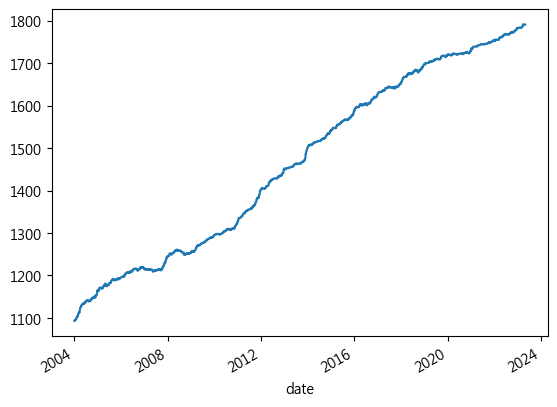

In [7]:
df_factor_all.groupby('date')['ticker'].count().plot()

In [8]:
df_price = pd.read_feather('data/cmoney_price.feather')
df_price = ut.cmoney_data_clean_up(df_price)
df_price['日期'] = pd.to_datetime(df_price['日期'])


df_price_sub = df_price[['日期','股票代號','收盤價','成交量','成交金額(千)']].copy()
df_price_sub.columns = ['date','ticker','close','volume','amount(k)']

df_price_sub.sort_values(["ticker", "date"], inplace=True)
df_price_sub.reset_index(drop=True, inplace=True)
df_price_sub['20_d_mean_amount_k'] = df_price_sub.groupby('ticker', as_index=False)['amount(k)'].rolling(20).mean()['amount(k)']


df_price_div = df_price[['日期','股票代號','收盤價']].copy()
df_price_div.columns = ['date','ticker','unadj_price']
df_price_div['date'] = pd.to_datetime(df_price_div['date'])
# sort by date for shift
df_price_div.sort_values(['ticker','date'],inplace=True)
# shift to get last day price
df_price_div['yesterday_price'] = df_price_div.groupby('ticker')['unadj_price'].shift(1)
df_price_div['unadj_price'] = df_price_div['unadj_price'].astype(float)
df_price_div['yesterday_price'] = df_price_div['yesterday_price'].astype(float)

In [9]:
# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_testing.feather')
# df_factor_all = pd.read_feather(f'data/df_factor_all.feather')

# create a dataframe for model mapping
df_model_mapping = pd.DataFrame()
df_model_mapping['rebalance_date'] = setting['rebalance_date_lst'][setting['start_index'] + 0:]
df_model_mapping['model_path'] = model_list
# convert rebalance_date to datetime
df_model_mapping['rebalance_date'] = pd.to_datetime(df_model_mapping['rebalance_date'])

# merge the df_model_mapping and df_factor_all
df_factor_all = pd.merge(df_factor_all, df_model_mapping, left_on='date', right_on='rebalance_date', how='left')
df_factor_all = df_factor_all.sort_values(['date','ticker']).reset_index(drop=True)
df_factor_all['model_path'].fillna(method='ffill', inplace=True)
df_factor_all['rebalance_date'].fillna(method='ffill', inplace=True)
df_factor_all.dropna(subset=['model_path'], inplace=True)
factor_columns = setting['factor_columns']
df_factor_all.dropna(subset=factor_columns, inplace=True)

df_factor_all = df_factor_all.reset_index(drop=True)

df_rebalance_date = pd.DataFrame()
df_rebalance_date['date'] = setting['rebalance_date_lst']
# set date to datetime format
df_rebalance_date['date'] = pd.to_datetime(df_rebalance_date['date'])
df_backtest_return = pd.merge(df_rebalance_date, df_adjusted_price, how='left', left_on='date', right_on='年月日')[['date','股票代號','收盤價(元)']].copy()

df_backtest_return.rename(columns={'股票代號':'ticker'}, inplace=True)
df_backtest_return.rename(columns={'收盤價(元)':'price'}, inplace=True)
df_backtest_return['price'] = df_backtest_return['price'].astype(float)
df_backtest_return['price_shift'] = df_backtest_return.groupby('ticker', group_keys=False)['price'].shift(-1)
df_backtest_return['rebalance_period_return'] = df_backtest_return['price_shift'] / df_backtest_return['price'] - 1

df_factor_all = df_factor_all.merge(df_backtest_return[['date','ticker','rebalance_period_return']], on=['date','ticker'], how='left')

df_factor_all_select = df_factor_all.copy()

df_factor_all.to_feather(f'./data/model/{model_folder_name}/df_factor_all_select.feather')

In [10]:
df_factor_all_reb = df_factor_all[df_factor_all['date'] == df_factor_all['rebalance_date']].copy()

In [11]:
df_factor_all_reb.sort_values(['date','ticker'], inplace=True)
df_factor_all_reb.reset_index(drop=True, inplace=True)

In [12]:
df_factor_all_reb['market_cap_billion'] = df_factor_all_reb['market_cap'] / 1000000
df_factor_all_reb['market_cap_rank'] = df_factor_all_reb.groupby('date')['market_cap'].rank(ascending=False)

In [13]:
# set market cap larger than 10 billion
df_plot_market_cap = df_factor_all_reb[df_factor_all_reb['market_cap_billion'] > 10].sort_values('market_cap_rank').groupby('date').tail(1)[['date','market_cap_rank']].reset_index(drop=True)
# plot market cap rank, with date as x-axis, with grid
# df_plot_market_cap.plot(x='date', y='market_cap_rank', figsize=(20, 8), title='market cap rank', grid=True)

# Define functions

In [103]:
def top_n(df, n=5, columns=['last_dividend_yield', 'predict_rank'], ascending=[False, True]):
    return df.sort_values(by=columns, ascending=ascending).head(n)

def get_daily_portfolio(df_rebalance, weight_type = 'vw', adjust_type = ["equal", "equal"],ratio: float = 0.5,weight_ratio: int = 1,rank_col: str = "rank",weight_col: str = "weight", weight_by_yields = False, replace_bottom='min'):

    df_portfolio_value_all = pd.DataFrame([])
    df_portfolio_detail_start = pd.DataFrame([])
    df_portfolio_detail_end = pd.DataFrame([])
    df_portfolio_detail_all = pd.DataFrame([])
    portfolio_quarterly_return = []
    portfolio_value = 1000000000

    for i in range(len(reb_lst) - 1):

        df_select_portfolio = df_rebalance.copy()

        df_select_portfolio_copy = df_select_portfolio[df_select_portfolio['date'] == reb_lst[i]].copy()
        df_select_portfolio_copy['weight'] = 1 / df_select_portfolio_copy.groupby('date')['ticker'].transform('count')
        df_select_portfolio_copy = ut.adjust_weights(df_select_portfolio_copy, adjust_type, ratio, weight_ratio, rank_col, weight_col)

        if weight_by_yields:
            if replace_bottom == 'min':
                df_select_portfolio_copy = ut.weight_by_yields(df_select_portfolio_copy, 5, 'adjusted_weight', 'min')
            if replace_bottom == 'q20':
                df_select_portfolio_copy = ut.weight_by_yields(df_select_portfolio_copy, 5, 'adjusted_weight', 'q20')
                
            use_weight_col = 'weight_by_yields'
        else:
            use_weight_col = 'adjusted_weight'

        df_select_portfolio_copy.sort_values('ticker', inplace=True)
        ticker_list = df_select_portfolio_copy['ticker'].unique()

        if weight_type == 'ew':
            if len(df_portfolio_value_all) == 0:
                df_select_portfolio_copy['portfolio_value'] = portfolio_value / len(ticker_list)
            else:
                df_select_portfolio_copy['portfolio_value'] = df_portfolio_value_all['portfolio_value'].iloc[-1] / len(ticker_list)

        if weight_type == 'vw':
            if len(df_portfolio_value_all) == 0:
                df_select_portfolio_copy['portfolio_value'] = portfolio_value * df_select_portfolio_copy[use_weight_col]
            else:
                df_select_portfolio_copy['portfolio_value'] = df_portfolio_value_all['portfolio_value'].iloc[-1] * df_select_portfolio_copy[use_weight_col]


        df_select_portfolio_copy.reset_index(drop=True, inplace=True)
        # give the weight to each stock by market cap
        # df_select_portfolio_copy['portfolio_value'] = df_select_portfolio_copy['portfolio_value'] * df_select_portfolio_copy['market_cap'] / df_select_portfolio_copy['market_cap'].sum()

        df_adjusted_price_temp_period = df_adjusted_price_temp[(df_adjusted_price_temp['ticker'].isin(ticker_list)) & (df_adjusted_price_temp['date'] >= reb_lst[i]) & (df_adjusted_price_temp['date'] <= reb_lst[i + 1])].copy()
        # check if there is price missing

        if df_adjusted_price_temp_period.groupby('ticker')['date'].count().max() != df_adjusted_price_temp_period.groupby('ticker')['date'].count().min():
            print('fuck')


        df_adjusted_price_temp_period.sort_values(['ticker','date'], inplace=True)
        df_adjusted_price_temp_period.reset_index(drop=True, inplace=True)
        df_adjusted_price_temp_period['price_shift'] = df_adjusted_price_temp_period.groupby('ticker')['price'].shift(1)
        df_adjusted_price_temp_period['rt'] = df_adjusted_price_temp_period['price'] / df_adjusted_price_temp_period['price_shift']
        df_adjusted_price_temp_period['rt'].fillna(1, inplace=True)
        # pivot the rt
        df_rt_pivot = df_adjusted_price_temp_period.pivot(index='date', columns='ticker', values='rt').copy()

        df_portfolio_value = df_rt_pivot.cumprod().mul(df_select_portfolio_copy['portfolio_value'].values).sum(axis=1).reset_index().rename(columns={0:'portfolio_value'})
        # print return by sub the last value by the first value
        portfolio_quarterly_return.append(df_portfolio_value['portfolio_value'].iloc[-1] / df_portfolio_value['portfolio_value'].iloc[0] - 1)

        df_portfolio_value_all = pd.concat([df_portfolio_value_all, df_portfolio_value], axis=0)

        df_portfolio_detail_start = pd.concat([df_portfolio_detail_start, pd.melt(df_rt_pivot.cumprod().mul(df_select_portfolio_copy['portfolio_value'].values).iloc[[0],:].reset_index(), id_vars = ['date'])], axis=0)
        df_portfolio_detail_end = pd.concat([df_portfolio_detail_end, pd.melt(df_rt_pivot.cumprod().mul(df_select_portfolio_copy['portfolio_value'].values).iloc[[-1],:].reset_index(), id_vars = ['date'])], axis=0)
        df_portfolio_detail_all = pd.concat([df_portfolio_detail_all, pd.melt(df_rt_pivot.cumprod().mul(df_select_portfolio_copy['portfolio_value'].values).reset_index(), id_vars = ['date'])], axis=0)

    df_portfolio_value_all = df_portfolio_value_all.copy()
    df_portfolio_value_all['date'] = pd.to_datetime(df_portfolio_value_all['date'])
    df_portfolio_value_all['portfolio_value'] = df_portfolio_value_all['portfolio_value'].round(0)
    df_portfolio_value_all = df_portfolio_value_all.drop_duplicates()

    return df_portfolio_value_all, df_portfolio_detail_start, df_portfolio_detail_end, df_portfolio_detail_all

def calc_sharpe_ratio(series):
    return ((series.pct_change().mean() * 252) / (series.pct_change().std() * np.sqrt(252)))

# calc the CAGR with the last value and the first value of portfolio value
def calculate_cagr(series):
    # get the last value of portfolio value
    last_value = series.iloc[-1]
    # get the first value of portfolio value
    first_value = series.iloc[0]
    # get the total number of years
    num_years = len(series) / 252
    # calc the CAGR
    cagr = (last_value / first_value)**(1/num_years) - 1
    return cagr

# Set Parmas

In [ ]:
CAP_TOP_options = [50]
CAP_BOT_options = [250]
AMOUNT_FLOOR_options = [50]
N_options = [40, 50]
TURNOVER_options = [10, 20]
TILTED_NUM_options = [0.2, 0.4]
TILTED_options = [0.2, 0.4]
LDY_WEIGHT_options = [0, 1, 3]
D1Y_WEIGHT_options = [0, 1, 3]

NUM_CUT = 5
result_lst = []
num_greed = 0

# Use itertools.product() to iterate through each combination
for CAP_TOP, CAP_BOT, AMOUNT_FLOOR, N, TURNOVER, TILTED_NUM, TILTED, LDY_WEIGHT, D1Y_WEIGHT in itertools.product(CAP_TOP_options, CAP_BOT_options, AMOUNT_FLOOR_options, N_options, TURNOVER_options, TILTED_NUM_options, TILTED_options, LDY_WEIGHT_options, D1Y_WEIGHT_options):

    df_sample_pool = df_factor_all_reb[(df_factor_all_reb["market_cap_rank"] > CAP_TOP) & (df_factor_all_reb["market_cap_rank"] <= CAP_BOT)].copy()

    df_sample_pool['roe_rank'] = df_sample_pool.groupby('date')['roe'].rank(ascending=False)
    df_sample_pool['roe_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['60_d_return_rank'] = df_sample_pool.groupby('date')['60_d_return'].rank(ascending=False)
    df_sample_pool['60_d_return_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['60_d_return_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['40_d_return_rank'] = df_sample_pool.groupby('date')['40_d_return'].rank(ascending=False)
    df_sample_pool['tobins_q_rank'] = df_sample_pool.groupby('date')['tobins_q'].rank(ascending=False)
    df_sample_pool['tobins_q_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['tobins_q_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['roe_4q_sum_rank'] = df_sample_pool.groupby('date')['roe_4q_sum'].rank(ascending=False)
    df_sample_pool['roe_4q_sum_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_4q_sum_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['ni_yoy_rank'] = df_sample_pool.groupby('date')['ni_yoy'].rank(ascending=False)
    df_sample_pool['ni_yoy_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['ni_yoy_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['last_dividend_yield_rank'] = df_sample_pool.groupby('date')['last_dividend_yield'].rank(ascending=False)
    df_sample_pool['dividend_1Y_sum_yield_rank'] = df_sample_pool.groupby('date')['dividend_1Y_sum_yield'].rank(ascending=False)
    # df_sample_pool['roe_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))
    df_sample_pool['ocf / asset_rank'] = df_sample_pool.groupby('date')['ocf / asset'].rank(ascending=False)
    df_sample_pool['ocf / asset_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['ocf / asset_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['rank_sum_1'] = df_sample_pool['roe_rank']
    df_sample_pool['rank_sum_1_rank'] = df_sample_pool.groupby('date')['rank_sum_1'].rank(ascending=True)
    df_sample_pool['rank_sum_1_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_1_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['rank_sum_2'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank']
    df_sample_pool['rank_sum_2_rank'] = df_sample_pool.groupby('date')['rank_sum_2'].rank(ascending=True)
    df_sample_pool['rank_sum_2_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_2_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['rank_sum_3'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank'] + df_sample_pool['ni_yoy_rank']
    df_sample_pool['rank_sum_3_rank'] = df_sample_pool.groupby('date')['rank_sum_3'].rank(ascending=True)
    df_sample_pool['rank_sum_3_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_3_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['rank_sum_average'] = df_sample_pool['rank_sum_3_rank'] + df_sample_pool['last_dividend_yield_rank'] * LDY_WEIGHT + df_sample_pool['dividend_1Y_sum_yield_rank'] * D1Y_WEIGHT

    df_temp = pd.merge(df_sample_pool, df_price_sub, how="left", on=["date", "ticker"])
    df_temp = df_temp.dropna()

    df_temp['20_d_mean_amount_floor'] = df_temp['20_d_mean_amount_k'] > AMOUNT_FLOOR * 1000

    df_liq_pool = df_temp[df_temp['20_d_mean_amount_floor'] == True].copy()

    reb_lst = df_factor_all['rebalance_date'].unique()
    apply_restrict_index = 0
    base_portfolio_number = N
    restrict_turnover = TURNOVER / 100
    sort_column = 'rank_sum_3_rank'
    remain_number =  int(np.ceil(base_portfolio_number * (1 - restrict_turnover)))

    # round up the restrict_portfolio_number
    restrict_portfolio_number =  (base_portfolio_number * 2 - remain_number)

    df_select_pool = df_liq_pool.reset_index(drop=True)
    # get the base portfolio by base_portfolio_number 
    df_select_pool_base = df_select_pool.groupby('date').apply(top_n, n = base_portfolio_number, columns=[sort_column], ascending=[True]).reset_index(drop=True)
    # get the restrict portfolio by restrict_portfolio_number
    df_select_pool_restrict = df_select_pool
    df_select_pool_restrict.reset_index(drop=True, inplace=True)

    apply_restrict_date = np.sort(reb_lst)[apply_restrict_index]
    # string format
    apply_restrict_date = pd.to_datetime(apply_restrict_date).strftime('%Y-%m-%d')

    df_restrict_result = pd.DataFrame([])
    # concat the data that date is smaller than apply_restrict_date to df_restrict_result
    df_restrict_result = pd.concat([df_restrict_result, df_select_pool_base[df_select_pool_base['date'] < apply_restrict_date]], axis=0)
    # print the max date in df_restrict_result

    for i in range(apply_restrict_index, len(reb_lst)):

        # get the slice data by reb_lst[i] in df_select_pool_restrict
        df_select_pool_restrict_temp = df_select_pool_restrict[df_select_pool_restrict['rebalance_date'] == reb_lst[i]].reset_index(drop=True)

        # get the slice data by reb_lst[i-1] in df_restrict_result, [i-1] is because we need to get the last portfolio
        df_restrict_result_temp = df_restrict_result[df_restrict_result['rebalance_date'] == reb_lst[i - 1]].reset_index(drop=True)

        # prepare the dataframe for finding the joint ticker
        df_new_temp = df_select_pool_restrict_temp[['date','ticker',sort_column, 'dividend_1Y_sum_yield']].copy()
        df_new_temp['restrict'] = 1
        df_new_temp.sort_values([sort_column,'dividend_1Y_sum_yield'], ascending=True, inplace=True)
        df_new_temp.reset_index(drop=True, inplace=True)

        last_portfolio_ticker_list = df_restrict_result_temp['ticker'].unique()

        df_priority_temp = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(last_portfolio_ticker_list)].copy()
        df_priority_temp.sort_values([sort_column,'dividend_1Y_sum_yield'], ascending=True, inplace=True)
        df_priority_temp.reset_index(drop=True, inplace=True)
        df_priority = df_priority_temp.head(remain_number)


        df_added = df_new_temp[df_new_temp['ticker'].isin(df_priority['ticker'].unique()) == False].head(base_portfolio_number - len(df_priority)).reset_index(drop=True)
        df_triviality = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(df_added['ticker'].unique())].reset_index(drop=True)

        df_restrict_result_temp = pd.concat([df_priority, df_triviality], axis=0)

        # concat the df_restrict_result_temp to df_restrict_result
        df_restrict_result = pd.concat([df_restrict_result, df_restrict_result_temp], axis=0)

    df_restrict_result.reset_index(drop=True, inplace=True)
    # df_restrict_result_return = df_restrict_result.groupby('date')['y'].mean()
    df_restrict_result_return = df_restrict_result.groupby('date')['rebalance_period_return'].mean()
    df_restrict_result['rank_sum_average_rank'] = df_restrict_result.groupby('date')['rank_sum_average'].rank(ascending=True)
    # Assuming your DataFrame is named df_returns

    df_adjusted_price_temp = df_adjusted_price.copy()
    df_adjusted_price_temp.columns = ['date','ticker','price']

    df_portfolio_value_all, df_portfolio_value_detail_start, df_portfolio_value_detail_end, df_portfolio_value_detail_all = get_daily_portfolio(df_restrict_result, 'vw', ['triangle','triangle'], TILTED_NUM, TILTED, 'rank_sum_average_rank', 'weight')

    df_compare_portfolio = df_portfolio_value_all.copy()
    df_compare_portfolio.columns = ['date','portfolio_value']

    df_benchmarks_all = pd.read_excel('./data/benchmarks.xlsx')
    df_benchmarks_all.columns = ['日期', 'TWA02', '台灣精選高息報酬指數', '台灣ESG低碳高息40報酬指數', '微波高息精選20報酬指數', '特選台灣產業龍頭存股等權重報酬指數', '存股雙十等權重報酬指數']
    benchmark_list = df_benchmarks_all.columns.to_list()
    benchmark_list.remove('日期')
    benchmark_list.remove('台灣精選高息報酬指數')
    benchmark_list.remove('特選台灣產業龍頭存股等權重報酬指數')

    index_name = benchmark_list[0]
    df_benchmarks_temp = df_benchmarks_all[['日期',f'{index_name}']].copy()
    df_benchmarks_temp.columns = ['date',f'{index_name}']
    df_benchmarks_temp.dropna(inplace=True)
    # change the date format to datetime
    df_benchmarks_temp['date'] = pd.to_datetime(df_benchmarks_temp['date'], format='%Y/%m/%d')
    df_benchmarks_temp.sort_values('date', inplace=True)
    df_benchmarks = df_benchmarks_temp.merge(df_compare_portfolio, on='date', how='left').dropna().copy()
    df_benchmarks.reset_index(drop=True, inplace=True)
    df_benchmarks.drop_duplicates(inplace=True)

    # df_benchmarks = df_benchmarks[df_benchmarks['date']> '2018-08-01']
    # scale the benchmark and portfolio value to 1
    df_benchmarks[f'{index_name}_scale'] = df_benchmarks[f'{index_name}'] / df_benchmarks[f'{index_name}'].iloc[0]
    df_benchmarks['portfolio_value_scale'] = df_benchmarks['portfolio_value'] / df_benchmarks['portfolio_value'].iloc[0]

    df_benchmarks.set_index('date', inplace=True)

    df_benchmarks['portfolio_value_rt'] = df_benchmarks['portfolio_value_scale'].pct_change()
    df_benchmarks[f'{index_name}_rt'] = df_benchmarks[f'{index_name}_scale'].pct_change()

    # calculate the beta of portfolio and benchmark
    beta = df_benchmarks[['portfolio_value_rt', f'{index_name}_rt']].cov().iloc[0,1] / df_benchmarks[f'{index_name}_rt'].var()
    print(f'beta: {beta:.2f}')

    # calculate the alpha of portfolio and benchmark
    alpha = df_benchmarks[['portfolio_value_rt', f'{index_name}_rt']].mean().iloc[0] - beta * df_benchmarks[f'{index_name}_rt'].mean()
    # annualize the alpha
    ann_alpha = (1+alpha)**240 - 1
    print(f'alpha: {ann_alpha:.2%}')

    df_benchmarks['year'] = df_benchmarks.index.year
    df_benchmarks['month'] = df_benchmarks.index.month
    df_benchmarks['quarter'] = df_benchmarks.index.quarter

    last_values = df_benchmarks.groupby(['year','month']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
    first_values  = df_benchmarks.groupby(['year','month']).head(1)[[f'{index_name}','portfolio_value_scale']].values
    df_monthly_return = pd.DataFrame(last_values / first_values)

    df_monthly_return.columns = [f'{index_name}','portfolio_value_scale']
    # drop the last row
    df_monthly_return = df_monthly_return[:-1]
    df_monthly_return['win_rate'] = np.where(df_monthly_return['portfolio_value_scale'] > df_monthly_return[f'{index_name}'], 1, 0)

    df_monthly_return['portfolio_rt'] = df_monthly_return['portfolio_value_scale'].pct_change()
    df_monthly_return[f'{index_name}_rt'] = df_monthly_return[f'{index_name}'].pct_change()
    last_values = df_benchmarks.groupby(['year','month']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
    first_values  = df_benchmarks.groupby(['year','month']).head(1)[[f'{index_name}','portfolio_value_scale']].values
    df_quarterly_return = pd.DataFrame(last_values / first_values)
    df_quarterly_return.columns = [f'{index_name}','portfolio_value_scale']
    df_quarterly_return['win_rate'] = np.where(df_quarterly_return['portfolio_value_scale'] > df_quarterly_return[f'{index_name}'], 1, 0)
    last_values = df_benchmarks.groupby(['year']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
    first_values  = df_benchmarks.groupby(['year']).head(1)[[f'{index_name}','portfolio_value_scale']].values
    df_yearly_return = pd.DataFrame(last_values / first_values)
    df_yearly_return.columns = [f'{index_name}','portfolio_value_scale']
    # drop the last row
    # df_yearly_return = df_yearly_return[:-1]
    df_yearly_return['win_rate'] = np.where(df_yearly_return['portfolio_value_scale'] > df_yearly_return[f'{index_name}'], 1, 0)
    # create a list from 2005 to 2023 for year column for df_yearly_return
    year_list = list(range(2005,2024))
    df_yearly_return['year'] = year_list

    df_yearly_return[['portfolio_value_scale',f'{index_name}']] = df_yearly_return[['portfolio_value_scale',f'{index_name}']] - 1

    df_benchmarks_temp.reset_index(inplace=True, drop=True)
    df_benchmarks_temp.set_index('date', inplace=True)

    

    # series_cagr = calculate_cagr(df_benchmarks[df_benchmarks.index > '2007-06-21'])[:3]
    series_cagr = calculate_cagr(df_benchmarks)[:2]
    series_sr = calc_sharpe_ratio(df_benchmarks)[:2]

    select_ticker = df_restrict_result['ticker'].unique()

    df_cash_dividends = pd.read_feather('data/tej_cash_dividends.feather')
    df_cash_dividends = ut.tej_data_clean_up(df_cash_dividends)
    df_cash_dividends = df_cash_dividends[['股票代號','除息日','息值(元)']].copy()
    df_cash_dividends.columns = ['ticker','date','dividend']
    df_cash_dividends = df_cash_dividends[df_cash_dividends['ticker'].isin(select_ticker)].copy()
    df_cash_dividends.drop_duplicates(inplace=True)
    df_cash_dividends['dividend'] = df_cash_dividends['dividend'].astype(float)
    df_cash_dividends = df_cash_dividends.groupby(['ticker','date']).sum().reset_index()

    df_factor_all_price = pd.merge(df_factor_all_select,df_price_div,on=['date','ticker'],how='left')
    df_factor_all_price_dividend = pd.merge(df_factor_all_price,df_cash_dividends,on=['date','ticker'],how='left')
    df_factor_all_price_dividend['unadj_yield'] = df_factor_all_price_dividend['dividend'] / df_factor_all_price_dividend['yesterday_price']

    # calculate the sum of dividend yield of each stock in each period 
    df_period_yield = df_factor_all_price_dividend.groupby(['ticker','rebalance_date'], as_index=False, group_keys=False)['unadj_yield'].sum()

    # merge the sum of dividend yield to df_dividend_select for calculate the portfolio dividend yield
    df_dividend_select_yield = pd.merge(df_restrict_result,df_period_yield,on=['ticker','rebalance_date'],how='left')

    # create the weight column for each ticker, weight = 1 / total num of ticker in the rebalance date
    df_dividend_select_yield['weight'] = 1 / df_dividend_select_yield.groupby('rebalance_date')['ticker'].transform('count')

    turnover_ratio_lst =  []

    for i in range(1, len(reb_lst) - 1):
        df_start_temp = df_portfolio_value_detail_start[df_portfolio_value_detail_start['date'].isin([reb_lst[i]])]
        df_end_temp = df_portfolio_value_detail_end[df_portfolio_value_detail_end['date'].isin([reb_lst[i]])]
        df_rebalance_temp = pd.merge(df_start_temp, df_end_temp, on=['date','ticker'], how='outer', suffixes=('_start', '_end')).fillna(0)
        df_rebalance_temp['turnover'] = abs(df_rebalance_temp['value_end'] - df_rebalance_temp['value_start'])
        turnover_ratio = (df_rebalance_temp['turnover'].sum() / df_start_temp['value'].sum()) / 2 * 100
        turnover_ratio_lst.append(turnover_ratio)

    # create a dataframe to store the turnover ratio with the rebalance date
    df_quarterly_turnover = pd.DataFrame({'date': reb_lst[1:-1], 'turnover': turnover_ratio_lst}).dropna()

    df_quarterly_turnover['year'] = df_quarterly_turnover['date'].dt.year
    df_quarterly_turnover['quarter'] = df_quarterly_turnover['date'].dt.quarter
    df_yearly_turnover = (df_quarterly_turnover.groupby('year')['turnover'].mean() * 4).reset_index()

    print(df_yearly_turnover['turnover'].mean())
    # df_yearly_turnover = df_quarterly_turnover.groupby('quarter')['turnover'].mean().reset_index()
    df_turnover = df_yearly_turnover['turnover'].describe().reset_index()
    df_turnover.columns = ['index_name', '一般版']

    df_dividend_select_yield_test = df_dividend_select_yield.copy()
    # df_dividend_select_yield_test = adjust_weights(df_dividend_select_yield_test, ['equal','equal'], 0.3, 0.5, 'rank_sum_average_rank', 'weight')
    df_dividend_select_yield_test = ut.adjust_weights(df_dividend_select_yield_test, ['triangle','triangle'], 0.4, TILTED, 'rank_sum_average_rank', 'weight')
    # df_dividend_select_yield_test[df_dividend_select_yield_test['date'] == '2005-02-25'].sort_values('rank_sum_average_rank').plot(x='rank_sum_average_rank', y=['weight','adjusted_weight'], kind='bar', figsize=(20, 10))

    df_dividend_select_yield_test['weight'] = 1 / df_dividend_select_yield_test.groupby('rebalance_date')['ticker'].transform('count')
    # df_dividend_select_yield_test['weighted_yield'] = df_dividend_select_yield_test['unadj_yield'] * df_dividend_select_yield_test['weight']
    df_dividend_select_yield_test['weighted_yield'] = df_dividend_select_yield_test['unadj_yield'] * df_dividend_select_yield_test['adjusted_weight']
    df_quarterly_div = df_dividend_select_yield_test.groupby('date')['weighted_yield'].sum().reset_index()
    df_quarterly_div['year'] = df_quarterly_div['date'].dt.year
    print(df_quarterly_div.groupby('year')['weighted_yield'].sum().mean())

    df_quarterly_div['year'] = df_quarterly_div['date'].dt.year

    mean_div = round(df_quarterly_div.groupby('year')['weighted_yield'].sum().mean() * 100, 2)

    # store the parameters and results in dictionary
    result_dict = {'CAP_TOP': CAP_TOP, 'CAP_BOT': CAP_BOT, 'AMOUNT_FLOOR': AMOUNT_FLOOR, 'N': N, 'TURNOVER': TURNOVER, 'TILTED_NUM': TILTED_NUM, 'TILTED': TILTED, "LDY_WEIGHT":LDY_WEIGHT , "D1Y_WEIGHT": D1Y_WEIGHT, 'SR_BENCHMARK': series_sr[0], 'CAGR_BENCHMARK': series_cagr[0], 'SR_PORTFOLIO': series_sr[1], 'CAGR_PORTFOLIO': series_cagr[1],  'BETA': beta, 'ALPHA': ann_alpha, 'DIVIDEND': mean_div, 'TURNOVER(%)': df_yearly_turnover['turnover'].mean()}

    # append the result_dict to result_lst
    result_lst.append(result_dict)

    num_greed += 1

df_greed = pd.DataFrame(result_lst)

# reorder the columns in df_greed by the order in result_dict
df_greed = df_greed[['CAP_TOP', 'CAP_BOT', 'AMOUNT_FLOOR', 'N', 'TURNOVER', 'TILTED_NUM', 'TILTED', 'LDY_WEIGHT', 'D1Y_WEIGHT', 'SR_BENCHMARK', 'CAGR_BENCHMARK', 'SR_PORTFOLIO', 'CAGR_PORTFOLIO', 'BETA', 'ALPHA', 'DIVIDEND', 'TURNOVER(%)']]


# 40 檔 50-200

50 200 50 40 10 0.2 0.4 3 1
beta: 1.04
alpha: 3.40%
97.13646191773461
0.04777369750894725
前5檔最大總和權重 2023-03-01 00:00:00 0.2674


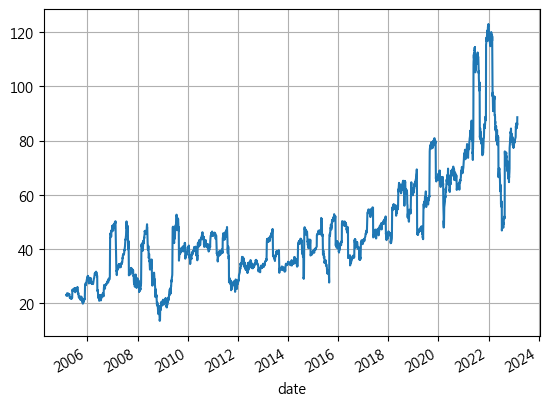

In [98]:
CAP_TOP_options = [50]
CAP_BOT_options = [200]
AMOUNT_FLOOR_options = [50]
N_options = [40]
TURNOVER_options = [10]
TILTED_NUM_options = [0.2]
TILTED_options = [0.4]
LDY_WEIGHT_options = [3]
D1Y_WEIGHT_options = [1]
WEIGHT_BY_YIELDS = False

NUM_CUT = 5
result_lst = []
num_greed = 0

for CAP_TOP, CAP_BOT, AMOUNT_FLOOR, N, TURNOVER, TILTED_NUM, TILTED, LDY_WEIGHT, D1Y_WEIGHT in itertools.product(CAP_TOP_options, CAP_BOT_options, AMOUNT_FLOOR_options, N_options, TURNOVER_options, TILTED_NUM_options, TILTED_options, LDY_WEIGHT_options, D1Y_WEIGHT_options):
    print(CAP_TOP, CAP_BOT, AMOUNT_FLOOR, N, TURNOVER, TILTED_NUM, TILTED, LDY_WEIGHT, D1Y_WEIGHT)
        
    df_sample_pool = df_factor_all_reb[(df_factor_all_reb["market_cap_rank"] > CAP_TOP) & (df_factor_all_reb["market_cap_rank"] <= CAP_BOT)].copy()

    df_sample_pool['roe_rank'] = df_sample_pool.groupby('date')['roe'].rank(ascending=False)
    df_sample_pool['roe_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['60_d_return_rank'] = df_sample_pool.groupby('date')['60_d_return'].rank(ascending=False)
    df_sample_pool['60_d_return_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['60_d_return_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['40_d_return_rank'] = df_sample_pool.groupby('date')['40_d_return'].rank(ascending=False)
    df_sample_pool['tobins_q_rank'] = df_sample_pool.groupby('date')['tobins_q'].rank(ascending=False)
    df_sample_pool['tobins_q_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['tobins_q_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['roe_4q_sum_rank'] = df_sample_pool.groupby('date')['roe_4q_sum'].rank(ascending=False)
    df_sample_pool['roe_4q_sum_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_4q_sum_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['ni_yoy_rank'] = df_sample_pool.groupby('date')['ni_yoy'].rank(ascending=False)
    df_sample_pool['ni_yoy_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['ni_yoy_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['last_dividend_yield_rank'] = df_sample_pool.groupby('date')['last_dividend_yield'].rank(ascending=False)
    df_sample_pool['dividend_1Y_sum_yield_rank'] = df_sample_pool.groupby('date')['dividend_1Y_sum_yield'].rank(ascending=False)
    # df_sample_pool['roe_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))
    df_sample_pool['ocf / asset_rank'] = df_sample_pool.groupby('date')['ocf / asset'].rank(ascending=False)
    df_sample_pool['ocf / asset_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['ocf / asset_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['rank_sum_1'] = df_sample_pool['roe_rank']
    df_sample_pool['rank_sum_1_rank'] = df_sample_pool.groupby('date')['rank_sum_1'].rank(ascending=True)
    df_sample_pool['rank_sum_1_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_1_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['rank_sum_2'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank']
    df_sample_pool['rank_sum_2_rank'] = df_sample_pool.groupby('date')['rank_sum_2'].rank(ascending=True)
    df_sample_pool['rank_sum_2_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_2_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['rank_sum_3'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank'] + df_sample_pool['ni_yoy_rank']
    df_sample_pool['rank_sum_3_rank'] = df_sample_pool.groupby('date')['rank_sum_3'].rank(ascending=True)
    df_sample_pool['rank_sum_3_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_3_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['rank_sum_average'] = df_sample_pool['rank_sum_3_rank'] + df_sample_pool['last_dividend_yield_rank'] * LDY_WEIGHT + df_sample_pool['dividend_1Y_sum_yield_rank'] * D1Y_WEIGHT

    df_temp = pd.merge(df_sample_pool, df_price_sub, how="left", on=["date", "ticker"])
    df_temp = df_temp.dropna()

    df_temp['20_d_mean_amount_floor'] = df_temp['20_d_mean_amount_k'] > AMOUNT_FLOOR * 1000

    df_liq_pool = df_temp[df_temp['20_d_mean_amount_floor'] == True].copy()

    reb_lst = df_factor_all['rebalance_date'].unique()
    apply_restrict_index = 0
    base_portfolio_number = N
    restrict_turnover = TURNOVER / 100
    sort_column = 'rank_sum_3_rank'
    remain_number =  int(np.ceil(base_portfolio_number * (1 - restrict_turnover)))

    # round up the restrict_portfolio_number
    restrict_portfolio_number =  (base_portfolio_number * 2 - remain_number)

    df_select_pool = df_liq_pool.reset_index(drop=True)
    # get the base portfolio by base_portfolio_number 
    df_select_pool_base = df_select_pool.groupby('date').apply(top_n, n = base_portfolio_number, columns=[sort_column], ascending=[True]).reset_index(drop=True)
    # get the restrict portfolio by restrict_portfolio_number
    df_select_pool_restrict = df_select_pool
    df_select_pool_restrict.reset_index(drop=True, inplace=True)

    apply_restrict_date = np.sort(reb_lst)[apply_restrict_index]
    # string format
    apply_restrict_date = pd.to_datetime(apply_restrict_date).strftime('%Y-%m-%d')

    df_restrict_result = pd.DataFrame([])
    # concat the data that date is smaller than apply_restrict_date to df_restrict_result
    df_restrict_result = pd.concat([df_restrict_result, df_select_pool_base[df_select_pool_base['date'] < apply_restrict_date]], axis=0)
    # print the max date in df_restrict_result

    for i in range(apply_restrict_index, len(reb_lst)):

        # get the slice data by reb_lst[i] in df_select_pool_restrict
        df_select_pool_restrict_temp = df_select_pool_restrict[df_select_pool_restrict['rebalance_date'] == reb_lst[i]].reset_index(drop=True)

        # get the slice data by reb_lst[i-1] in df_restrict_result, [i-1] is because we need to get the last portfolio
        df_restrict_result_temp = df_restrict_result[df_restrict_result['rebalance_date'] == reb_lst[i - 1]].reset_index(drop=True)

        # prepare the dataframe for finding the joint ticker
        df_new_temp = df_select_pool_restrict_temp[['date','ticker',sort_column, 'dividend_1Y_sum_yield']].copy()
        df_new_temp['restrict'] = 1
        df_new_temp.sort_values([sort_column,'dividend_1Y_sum_yield'], ascending=True, inplace=True)
        df_new_temp.reset_index(drop=True, inplace=True)

        last_portfolio_ticker_list = df_restrict_result_temp['ticker'].unique()

        df_priority_temp = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(last_portfolio_ticker_list)].copy()
        df_priority_temp.sort_values([sort_column,'dividend_1Y_sum_yield'], ascending=True, inplace=True)
        df_priority_temp.reset_index(drop=True, inplace=True)
        df_priority = df_priority_temp.head(remain_number)


        df_added = df_new_temp[df_new_temp['ticker'].isin(df_priority['ticker'].unique()) == False].head(base_portfolio_number - len(df_priority)).reset_index(drop=True)
        df_triviality = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(df_added['ticker'].unique())].reset_index(drop=True)

        df_restrict_result_temp = pd.concat([df_priority, df_triviality], axis=0)

        # concat the df_restrict_result_temp to df_restrict_result
        df_restrict_result = pd.concat([df_restrict_result, df_restrict_result_temp], axis=0)

    df_restrict_result.reset_index(drop=True, inplace=True)
    # df_restrict_result_return = df_restrict_result.groupby('date')['y'].mean()
    df_restrict_result_return = df_restrict_result.groupby('date')['rebalance_period_return'].mean()
    df_restrict_result['rank_sum_average_rank'] = df_restrict_result.groupby('date')['rank_sum_average'].rank(ascending=True)
    # Assuming your DataFrame is named df_returns

    df_adjusted_price_temp = df_adjusted_price.copy()
    df_adjusted_price_temp.columns = ['date','ticker','price']

    df_portfolio_value_all, df_portfolio_value_detail_start, df_portfolio_value_detail_end, df_portfolio_value_detail_all = get_daily_portfolio(df_restrict_result, 'vw', ['triangle','triangle'], TILTED_NUM, TILTED, 'rank_sum_average_rank', 'weight', WEIGHT_BY_YIELDS)

    df_compare_portfolio = df_portfolio_value_all.copy()
    df_compare_portfolio.columns = ['date','portfolio_value']

    df_benchmarks_all = pd.read_excel('./data/benchmarks.xlsx')
    df_benchmarks_all.columns = ['日期', 'TWA02', '台灣精選高息報酬指數', '台灣ESG低碳高息40報酬指數', '微波高息精選20報酬指數', '特選台灣產業龍頭存股等權重報酬指數', '存股雙十等權重報酬指數']
    benchmark_list = df_benchmarks_all.columns.to_list()
    benchmark_list.remove('日期')
    benchmark_list.remove('台灣精選高息報酬指數')
    benchmark_list.remove('特選台灣產業龍頭存股等權重報酬指數')

    index_name = benchmark_list[0]
    df_benchmarks_temp = df_benchmarks_all[['日期',f'{index_name}']].copy()
    df_benchmarks_temp.columns = ['date',f'{index_name}']
    df_benchmarks_temp.dropna(inplace=True)
    # change the date format to datetime
    df_benchmarks_temp['date'] = pd.to_datetime(df_benchmarks_temp['date'], format='%Y/%m/%d')
    df_benchmarks_temp.sort_values('date', inplace=True)
    df_benchmarks = df_benchmarks_temp.merge(df_compare_portfolio, on='date', how='left').dropna().copy()
    df_benchmarks.reset_index(drop=True, inplace=True)
    df_benchmarks.drop_duplicates(inplace=True)

    # df_benchmarks = df_benchmarks[df_benchmarks['date']> '2018-08-01']
    # scale the benchmark and portfolio value to 1
    df_benchmarks[f'{index_name}_scale'] = df_benchmarks[f'{index_name}'] / df_benchmarks[f'{index_name}'].iloc[0]
    df_benchmarks['portfolio_value_scale'] = df_benchmarks['portfolio_value'] / df_benchmarks['portfolio_value'].iloc[0]

    df_benchmarks.set_index('date', inplace=True)

    df_benchmarks['portfolio_value_rt'] = df_benchmarks['portfolio_value_scale'].pct_change()
    df_benchmarks[f'{index_name}_rt'] = df_benchmarks[f'{index_name}_scale'].pct_change()

    # calculate the beta of portfolio and benchmark
    beta = df_benchmarks[['portfolio_value_rt', f'{index_name}_rt']].cov().iloc[0,1] / df_benchmarks[f'{index_name}_rt'].var()
    print(f'beta: {beta:.2f}')

    # calculate the alpha of portfolio and benchmark
    alpha = df_benchmarks[['portfolio_value_rt', f'{index_name}_rt']].mean().iloc[0] - beta * df_benchmarks[f'{index_name}_rt'].mean()
    # annualize the alpha
    ann_alpha = (1+alpha)**240 - 1
    print(f'alpha: {ann_alpha:.2%}')

    df_benchmarks['year'] = df_benchmarks.index.year
    df_benchmarks['month'] = df_benchmarks.index.month
    df_benchmarks['quarter'] = df_benchmarks.index.quarter

    last_values = df_benchmarks.groupby(['year','month']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
    first_values  = df_benchmarks.groupby(['year','month']).head(1)[[f'{index_name}','portfolio_value_scale']].values
    df_monthly_return = pd.DataFrame(last_values / first_values)

    df_monthly_return.columns = [f'{index_name}','portfolio_value_scale']
    # drop the last row
    df_monthly_return = df_monthly_return[:-1]
    df_monthly_return['win_rate'] = np.where(df_monthly_return['portfolio_value_scale'] > df_monthly_return[f'{index_name}'], 1, 0)

    df_monthly_return['portfolio_rt'] = df_monthly_return['portfolio_value_scale'].pct_change()
    df_monthly_return[f'{index_name}_rt'] = df_monthly_return[f'{index_name}'].pct_change()
    last_values = df_benchmarks.groupby(['year','month']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
    first_values  = df_benchmarks.groupby(['year','month']).head(1)[[f'{index_name}','portfolio_value_scale']].values
    df_quarterly_return = pd.DataFrame(last_values / first_values)
    df_quarterly_return.columns = [f'{index_name}','portfolio_value_scale']
    df_quarterly_return['win_rate'] = np.where(df_quarterly_return['portfolio_value_scale'] > df_quarterly_return[f'{index_name}'], 1, 0)
    last_values = df_benchmarks.groupby(['year']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
    first_values  = df_benchmarks.groupby(['year']).head(1)[[f'{index_name}','portfolio_value_scale']].values
    df_yearly_return = pd.DataFrame(last_values / first_values)
    df_yearly_return.columns = [f'{index_name}','portfolio_value_scale']
    # drop the last row
    # df_yearly_return = df_yearly_return[:-1]
    df_yearly_return['win_rate'] = np.where(df_yearly_return['portfolio_value_scale'] > df_yearly_return[f'{index_name}'], 1, 0)
    # create a list from 2005 to 2023 for year column for df_yearly_return
    year_list = list(range(2005,2024))
    df_yearly_return['year'] = year_list

    df_yearly_return[['portfolio_value_scale',f'{index_name}']] = df_yearly_return[['portfolio_value_scale',f'{index_name}']] - 1

    df_benchmarks_temp.reset_index(inplace=True, drop=True)
    df_benchmarks_temp.set_index('date', inplace=True)
    
    # series_cagr = calculate_cagr(df_benchmarks[df_benchmarks.index > '2007-06-21'])[:3]
    series_cagr = calculate_cagr(df_benchmarks)[:2]
    series_sr = calc_sharpe_ratio(df_benchmarks)[:2]

    select_ticker = df_restrict_result['ticker'].unique()

    df_cash_dividends = pd.read_feather('data/tej_cash_dividends.feather')
    df_cash_dividends = ut.tej_data_clean_up(df_cash_dividends)
    df_cash_dividends = df_cash_dividends[['股票代號','除息日','息值(元)']].copy()
    df_cash_dividends.columns = ['ticker','date','dividend']
    df_cash_dividends = df_cash_dividends[df_cash_dividends['ticker'].isin(select_ticker)].copy()
    df_cash_dividends.drop_duplicates(inplace=True)
    df_cash_dividends['dividend'] = df_cash_dividends['dividend'].astype(float)
    df_cash_dividends = df_cash_dividends.groupby(['ticker','date']).sum().reset_index()

    df_factor_all_price = pd.merge(df_factor_all_select,df_price_div,on=['date','ticker'],how='left')
    df_factor_all_price_dividend = pd.merge(df_factor_all_price,df_cash_dividends,on=['date','ticker'],how='left')
    df_factor_all_price_dividend['unadj_yield'] = df_factor_all_price_dividend['dividend'] / df_factor_all_price_dividend['yesterday_price']

    # calculate the sum of dividend yield of each stock in each period 
    df_period_yield = df_factor_all_price_dividend.groupby(['ticker','rebalance_date'], as_index=False, group_keys=False)['unadj_yield'].sum()

    # merge the sum of dividend yield to df_dividend_select for calculate the portfolio dividend yield
    df_dividend_select_yield = pd.merge(df_restrict_result,df_period_yield,on=['ticker','rebalance_date'],how='left')

    # create the weight column for each ticker, weight = 1 / total num of ticker in the rebalance date
    df_dividend_select_yield['weight'] = 1 / df_dividend_select_yield.groupby('rebalance_date')['ticker'].transform('count')

    turnover_ratio_lst =  []

    for i in range(1, len(reb_lst) - 1):
        df_start_temp = df_portfolio_value_detail_start[df_portfolio_value_detail_start['date'].isin([reb_lst[i]])]
        df_end_temp = df_portfolio_value_detail_end[df_portfolio_value_detail_end['date'].isin([reb_lst[i]])]
        df_rebalance_temp = pd.merge(df_start_temp, df_end_temp, on=['date','ticker'], how='outer', suffixes=('_start', '_end')).fillna(0)
        df_rebalance_temp['turnover'] = abs(df_rebalance_temp['value_end'] - df_rebalance_temp['value_start'])
        turnover_ratio = (df_rebalance_temp['turnover'].sum() / df_start_temp['value'].sum()) / 2 * 100
        turnover_ratio_lst.append(turnover_ratio)

    # create a dataframe to store the turnover ratio with the rebalance date
    df_quarterly_turnover = pd.DataFrame({'date': reb_lst[1:-1], 'turnover': turnover_ratio_lst}).dropna()

    df_quarterly_turnover['year'] = df_quarterly_turnover['date'].dt.year
    df_quarterly_turnover['quarter'] = df_quarterly_turnover['date'].dt.quarter
    df_yearly_turnover = (df_quarterly_turnover.groupby('year')['turnover'].mean() * 4).reset_index()

    print(df_yearly_turnover['turnover'].mean())
    # df_yearly_turnover = df_quarterly_turnover.groupby('quarter')['turnover'].mean().reset_index()
    df_turnover = df_yearly_turnover['turnover'].describe().reset_index()
    df_turnover.columns = ['index_name', '一般版']

    df_dividend_select_yield_test = df_dividend_select_yield.copy()
    # df_dividend_select_yield_test = adjust_weights(df_dividend_select_yield_test, ['equal','equal'], 0.3, 0.5, 'rank_sum_average_rank', 'weight')
    df_dividend_select_yield_test = ut.adjust_weights(df_dividend_select_yield_test, ['triangle','triangle'], TILTED_NUM, TILTED, 'rank_sum_average_rank', 'weight')
    df_dividend_select_yield_test = ut.weight_by_yields(df_dividend_select_yield_test, 5, 'adjusted_weight')

    if WEIGHT_BY_YIELDS:
        use_weight = 'weight_by_yields'
    else:
        use_weight = 'adjusted_weight'

    df_dividend_select_yield_test['weighted_yield'] = df_dividend_select_yield_test['unadj_yield'] * df_dividend_select_yield_test[use_weight]
    
    df_quarterly_div = df_dividend_select_yield_test.groupby('date')['weighted_yield'].sum().reset_index()
    df_quarterly_div['year'] = df_quarterly_div['date'].dt.year
    print(df_quarterly_div.groupby('year')['weighted_yield'].sum().mean())

    df_quarterly_div['year'] = df_quarterly_div['date'].dt.year

    mean_div = round(df_quarterly_div.groupby('year')['weighted_yield'].sum().mean() * 100, 2)

    # save the params and result to a dictionary
    params_dict = {
        'CAP_TOP': CAP_TOP,
        'CAP_BOT': CAP_BOT,
        'AMOUNT_FLOOR': AMOUNT_FLOOR,
        'N': N,
        'TURNOVER': TURNOVER,
        'TILTED_NUM': TILTED_NUM,
        'TILTED': TILTED,
        'LDY_WEIGHT': LDY_WEIGHT,
        'D1Y_WEIGHT': D1Y_WEIGHT,
        'WEIGHT_BY_YIELDS': WEIGHT_BY_YIELDS,
        'SR_BENCH': round(series_sr[0], 2),
        'SR_PORT': round(series_sr[1], 2),
        'CAGR_BENCH': round(series_cagr[0], 4),
        'CAGR_PORT': round(series_cagr[1], 4),
        'ALPHA': round(ann_alpha, 4),
        'BETA': round(beta, 4),
        'MEAN_DIV': round(mean_div, 4),
        'TURNOVER(%)': round(df_turnover[df_turnover['index_name'] == 'mean']['一般版'].values[0], 2)
    }
    # concat the params with "_" for the json filename
    params_str = '_'.join([str(v) for v in params_dict.values()])

    # save the dictionary to json file
    with open(f'./figs/{params_str}.json', 'w') as f:
        json.dump(params_dict, f)

        
df_weight_detail = df_portfolio_value_detail_all.sort_values(['date','ticker']).reset_index(drop=True).copy()

# Compute the total value for each date
total_value = df_weight_detail.groupby('date')['value'].transform('sum')

# Compute the weight of each ticker by dividing its value by the total value for its date
df_weight_detail['weight'] = df_weight_detail['value'] / total_value

df_top_5_weighting = df_weight_detail.sort_values(['date','weight'], ascending = False).groupby('date').head(5).copy()
df_top_5_weighting = df_top_5_weighting.groupby('date')['weight'].sum().reset_index()
print("前5檔最大總和權重",df_top_5_weighting.max()['date'], round(df_top_5_weighting.max()['weight'], 4))

df_market_cap_copy = df_factor_all[['date','ticker','market_cap']].copy()

df_weight_detail = pd.merge(df_weight_detail, df_market_cap_copy, on = ['date','ticker'], how = 'left').copy()

df_weight_detail['max_aum_assumption'] = df_weight_detail['market_cap'] * 0.1 / df_weight_detail['weight'] / 1000000
df_weight_detail[df_weight_detail['date'].isin(reb_lst) == False].groupby('date')['max_aum_assumption'].min().plot()

plt.grid()

plt.savefig(f'./figs/{params_str}_max_aum_assumption.png', dpi=300)

pd.DataFrame([params_dict]).iloc[:,:5].dfi.export(f'./figs/table_{params_str}_1.png')
pd.DataFrame([params_dict]).iloc[:,6:10].dfi.export(f'./figs/table_{params_str}_2.png')
pd.DataFrame([params_dict]).iloc[:,10:14].dfi.export(f'./figs/table_{params_str}_3.png')
pd.DataFrame([params_dict]).iloc[:,14:].dfi.export(f'./figs/table_{params_str}_4.png')

# loop the f'./figs/table_{params_str}_1.png' to 4
for i in range(1, 5):
    ut.crop_index(f'./figs/table_{params_str}_{i}.png')

ut.merge_images([f'./figs/table_{params_str}_{i}.png' for i in range(1, 5)], f'./figs/{params_str}_table.png', 10)

# delete all the f'./figs/table_{params_str}_{i}.png'
for i in range(1, 5):
    os.remove(f'./figs/table_{params_str}_{i}.png')

# 50 檔 50-250

50 250 50 50 20 0.4 0.4 3 3
beta: 1.04
alpha: 4.09%
123.85002340676562
0.05398672219869389
前5檔最大總和權重 2023-03-01 00:00:00 0.2535


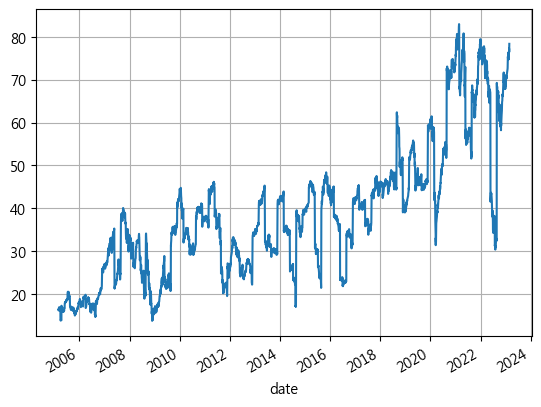

In [107]:
CAP_TOP_options = [50]
CAP_BOT_options = [250]
AMOUNT_FLOOR_options = [50]
N_options = [50]
TURNOVER_options = [20]
TILTED_NUM_options = [0.4]
TILTED_options = [0.4]
LDY_WEIGHT_options = [3]
D1Y_WEIGHT_options = [3]
WEIGHT_BY_YIELDS = True

NUM_CUT = 5
result_lst = []
num_greed = 0

for CAP_TOP, CAP_BOT, AMOUNT_FLOOR, N, TURNOVER, TILTED_NUM, TILTED, LDY_WEIGHT, D1Y_WEIGHT in itertools.product(CAP_TOP_options, CAP_BOT_options, AMOUNT_FLOOR_options, N_options, TURNOVER_options, TILTED_NUM_options, TILTED_options, LDY_WEIGHT_options, D1Y_WEIGHT_options):
    print(CAP_TOP, CAP_BOT, AMOUNT_FLOOR, N, TURNOVER, TILTED_NUM, TILTED, LDY_WEIGHT, D1Y_WEIGHT)
        
    df_sample_pool = df_factor_all_reb[(df_factor_all_reb["market_cap_rank"] > CAP_TOP) & (df_factor_all_reb["market_cap_rank"] <= CAP_BOT)].copy()

    df_sample_pool['roe_rank'] = df_sample_pool.groupby('date')['roe'].rank(ascending=False)
    df_sample_pool['roe_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['60_d_return_rank'] = df_sample_pool.groupby('date')['60_d_return'].rank(ascending=False)
    df_sample_pool['60_d_return_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['60_d_return_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['40_d_return_rank'] = df_sample_pool.groupby('date')['40_d_return'].rank(ascending=False)
    df_sample_pool['tobins_q_rank'] = df_sample_pool.groupby('date')['tobins_q'].rank(ascending=False)
    df_sample_pool['tobins_q_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['tobins_q_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['roe_4q_sum_rank'] = df_sample_pool.groupby('date')['roe_4q_sum'].rank(ascending=False)
    df_sample_pool['roe_4q_sum_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_4q_sum_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['ni_yoy_rank'] = df_sample_pool.groupby('date')['ni_yoy'].rank(ascending=False)
    df_sample_pool['ni_yoy_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['ni_yoy_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['last_dividend_yield_rank'] = df_sample_pool.groupby('date')['last_dividend_yield'].rank(ascending=False)
    df_sample_pool['dividend_1Y_sum_yield_rank'] = df_sample_pool.groupby('date')['dividend_1Y_sum_yield'].rank(ascending=False)
    # df_sample_pool['roe_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['roe_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))
    df_sample_pool['ocf / asset_rank'] = df_sample_pool.groupby('date')['ocf / asset'].rank(ascending=False)
    df_sample_pool['ocf / asset_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['ocf / asset_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['rank_sum_1'] = df_sample_pool['roe_rank']
    df_sample_pool['rank_sum_1_rank'] = df_sample_pool.groupby('date')['rank_sum_1'].rank(ascending=True)
    df_sample_pool['rank_sum_1_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_1_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['rank_sum_2'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank']
    df_sample_pool['rank_sum_2_rank'] = df_sample_pool.groupby('date')['rank_sum_2'].rank(ascending=True)
    df_sample_pool['rank_sum_2_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_2_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['rank_sum_3'] = df_sample_pool['roe_rank'] + df_sample_pool['60_d_return_rank'] + df_sample_pool['ni_yoy_rank']
    df_sample_pool['rank_sum_3_rank'] = df_sample_pool.groupby('date')['rank_sum_3'].rank(ascending=True)
    df_sample_pool['rank_sum_3_rank_qcut'] = df_sample_pool.groupby('date', group_keys=False)['rank_sum_3_rank'].apply(lambda x: pd.qcut(x, NUM_CUT, labels=False, duplicates="drop"))

    df_sample_pool['rank_sum_average'] = df_sample_pool['rank_sum_3_rank'] + df_sample_pool['last_dividend_yield_rank'] * LDY_WEIGHT + df_sample_pool['dividend_1Y_sum_yield_rank'] * D1Y_WEIGHT

    df_temp = pd.merge(df_sample_pool, df_price_sub, how="left", on=["date", "ticker"])
    df_temp = df_temp.dropna()

    df_temp['20_d_mean_amount_floor'] = df_temp['20_d_mean_amount_k'] > AMOUNT_FLOOR * 1000

    df_liq_pool = df_temp[df_temp['20_d_mean_amount_floor'] == True].copy()

    reb_lst = df_factor_all['rebalance_date'].unique()
    apply_restrict_index = 0
    base_portfolio_number = N
    restrict_turnover = TURNOVER / 100
    sort_column = 'rank_sum_3_rank'
    remain_number =  int(np.ceil(base_portfolio_number * (1 - restrict_turnover)))

    # round up the restrict_portfolio_number
    restrict_portfolio_number =  (base_portfolio_number * 2 - remain_number)

    df_select_pool = df_liq_pool.reset_index(drop=True)
    # get the base portfolio by base_portfolio_number 
    df_select_pool_base = df_select_pool.groupby('date').apply(top_n, n = base_portfolio_number, columns=[sort_column], ascending=[True]).reset_index(drop=True)
    # get the restrict portfolio by restrict_portfolio_number
    df_select_pool_restrict = df_select_pool
    df_select_pool_restrict.reset_index(drop=True, inplace=True)

    apply_restrict_date = np.sort(reb_lst)[apply_restrict_index]
    # string format
    apply_restrict_date = pd.to_datetime(apply_restrict_date).strftime('%Y-%m-%d')

    df_restrict_result = pd.DataFrame([])
    # concat the data that date is smaller than apply_restrict_date to df_restrict_result
    df_restrict_result = pd.concat([df_restrict_result, df_select_pool_base[df_select_pool_base['date'] < apply_restrict_date]], axis=0)
    # print the max date in df_restrict_result

    for i in range(apply_restrict_index, len(reb_lst)):

        # get the slice data by reb_lst[i] in df_select_pool_restrict
        df_select_pool_restrict_temp = df_select_pool_restrict[df_select_pool_restrict['rebalance_date'] == reb_lst[i]].reset_index(drop=True)

        # get the slice data by reb_lst[i-1] in df_restrict_result, [i-1] is because we need to get the last portfolio
        df_restrict_result_temp = df_restrict_result[df_restrict_result['rebalance_date'] == reb_lst[i - 1]].reset_index(drop=True)

        # prepare the dataframe for finding the joint ticker
        df_new_temp = df_select_pool_restrict_temp[['date','ticker',sort_column, 'dividend_1Y_sum_yield']].copy()
        df_new_temp['restrict'] = 1
        df_new_temp.sort_values([sort_column,'dividend_1Y_sum_yield'], ascending=True, inplace=True)
        df_new_temp.reset_index(drop=True, inplace=True)

        last_portfolio_ticker_list = df_restrict_result_temp['ticker'].unique()

        df_priority_temp = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(last_portfolio_ticker_list)].copy()
        df_priority_temp.sort_values([sort_column,'dividend_1Y_sum_yield'], ascending=True, inplace=True)
        df_priority_temp.reset_index(drop=True, inplace=True)
        df_priority = df_priority_temp.head(remain_number)


        df_added = df_new_temp[df_new_temp['ticker'].isin(df_priority['ticker'].unique()) == False].head(base_portfolio_number - len(df_priority)).reset_index(drop=True)
        df_triviality = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(df_added['ticker'].unique())].reset_index(drop=True)

        df_restrict_result_temp = pd.concat([df_priority, df_triviality], axis=0)

        # concat the df_restrict_result_temp to df_restrict_result
        df_restrict_result = pd.concat([df_restrict_result, df_restrict_result_temp], axis=0)

    df_restrict_result.reset_index(drop=True, inplace=True)
    # df_restrict_result_return = df_restrict_result.groupby('date')['y'].mean()
    df_restrict_result_return = df_restrict_result.groupby('date')['rebalance_period_return'].mean()
    df_restrict_result['rank_sum_average_rank'] = df_restrict_result.groupby('date')['rank_sum_average'].rank(ascending=True)
    # Assuming your DataFrame is named df_returns

    df_adjusted_price_temp = df_adjusted_price.copy()
    df_adjusted_price_temp.columns = ['date','ticker','price']

    df_portfolio_value_all, df_portfolio_value_detail_start, df_portfolio_value_detail_end, df_portfolio_value_detail_all = get_daily_portfolio(df_restrict_result, 'vw', ['triangle','triangle'], TILTED_NUM, TILTED, 'rank_sum_average_rank', 'weight', WEIGHT_BY_YIELDS)

    df_compare_portfolio = df_portfolio_value_all.copy()
    df_compare_portfolio.columns = ['date','portfolio_value']

    df_benchmarks_all = pd.read_excel('./data/benchmarks.xlsx')
    df_benchmarks_all.columns = ['日期', 'TWA02', '台灣精選高息報酬指數', '台灣ESG低碳高息40報酬指數', '微波高息精選20報酬指數', '特選台灣產業龍頭存股等權重報酬指數', '存股雙十等權重報酬指數']
    benchmark_list = df_benchmarks_all.columns.to_list()
    benchmark_list.remove('日期')
    benchmark_list.remove('台灣精選高息報酬指數')
    benchmark_list.remove('特選台灣產業龍頭存股等權重報酬指數')

    index_name = benchmark_list[0]
    df_benchmarks_temp = df_benchmarks_all[['日期',f'{index_name}']].copy()
    df_benchmarks_temp.columns = ['date',f'{index_name}']
    df_benchmarks_temp.dropna(inplace=True)
    # change the date format to datetime
    df_benchmarks_temp['date'] = pd.to_datetime(df_benchmarks_temp['date'], format='%Y/%m/%d')
    df_benchmarks_temp.sort_values('date', inplace=True)
    df_benchmarks = df_benchmarks_temp.merge(df_compare_portfolio, on='date', how='left').dropna().copy()
    df_benchmarks.reset_index(drop=True, inplace=True)
    df_benchmarks.drop_duplicates(inplace=True)

    # df_benchmarks = df_benchmarks[df_benchmarks['date']> '2018-08-01']
    # scale the benchmark and portfolio value to 1
    df_benchmarks[f'{index_name}_scale'] = df_benchmarks[f'{index_name}'] / df_benchmarks[f'{index_name}'].iloc[0]
    df_benchmarks['portfolio_value_scale'] = df_benchmarks['portfolio_value'] / df_benchmarks['portfolio_value'].iloc[0]

    df_benchmarks.set_index('date', inplace=True)

    df_benchmarks['portfolio_value_rt'] = df_benchmarks['portfolio_value_scale'].pct_change()
    df_benchmarks[f'{index_name}_rt'] = df_benchmarks[f'{index_name}_scale'].pct_change()

    # calculate the beta of portfolio and benchmark
    beta = df_benchmarks[['portfolio_value_rt', f'{index_name}_rt']].cov().iloc[0,1] / df_benchmarks[f'{index_name}_rt'].var()
    print(f'beta: {beta:.2f}')

    # calculate the alpha of portfolio and benchmark
    alpha = df_benchmarks[['portfolio_value_rt', f'{index_name}_rt']].mean().iloc[0] - beta * df_benchmarks[f'{index_name}_rt'].mean()
    # annualize the alpha
    ann_alpha = (1+alpha)**240 - 1
    print(f'alpha: {ann_alpha:.2%}')

    df_benchmarks['year'] = df_benchmarks.index.year
    df_benchmarks['month'] = df_benchmarks.index.month
    df_benchmarks['quarter'] = df_benchmarks.index.quarter

    last_values = df_benchmarks.groupby(['year','month']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
    first_values  = df_benchmarks.groupby(['year','month']).head(1)[[f'{index_name}','portfolio_value_scale']].values
    df_monthly_return = pd.DataFrame(last_values / first_values)

    df_monthly_return.columns = [f'{index_name}','portfolio_value_scale']
    # drop the last row
    df_monthly_return = df_monthly_return[:-1]
    df_monthly_return['win_rate'] = np.where(df_monthly_return['portfolio_value_scale'] > df_monthly_return[f'{index_name}'], 1, 0)

    df_monthly_return['portfolio_rt'] = df_monthly_return['portfolio_value_scale'].pct_change()
    df_monthly_return[f'{index_name}_rt'] = df_monthly_return[f'{index_name}'].pct_change()
    last_values = df_benchmarks.groupby(['year','month']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
    first_values  = df_benchmarks.groupby(['year','month']).head(1)[[f'{index_name}','portfolio_value_scale']].values
    df_quarterly_return = pd.DataFrame(last_values / first_values)
    df_quarterly_return.columns = [f'{index_name}','portfolio_value_scale']
    df_quarterly_return['win_rate'] = np.where(df_quarterly_return['portfolio_value_scale'] > df_quarterly_return[f'{index_name}'], 1, 0)
    last_values = df_benchmarks.groupby(['year']).tail(1)[[f'{index_name}','portfolio_value_scale']].values
    first_values  = df_benchmarks.groupby(['year']).head(1)[[f'{index_name}','portfolio_value_scale']].values
    df_yearly_return = pd.DataFrame(last_values / first_values)
    df_yearly_return.columns = [f'{index_name}','portfolio_value_scale']
    # drop the last row
    # df_yearly_return = df_yearly_return[:-1]
    df_yearly_return['win_rate'] = np.where(df_yearly_return['portfolio_value_scale'] > df_yearly_return[f'{index_name}'], 1, 0)
    # create a list from 2005 to 2023 for year column for df_yearly_return
    year_list = list(range(2005,2024))
    df_yearly_return['year'] = year_list

    df_yearly_return[['portfolio_value_scale',f'{index_name}']] = df_yearly_return[['portfolio_value_scale',f'{index_name}']] - 1

    df_benchmarks_temp.reset_index(inplace=True, drop=True)
    df_benchmarks_temp.set_index('date', inplace=True)
    
    # series_cagr = calculate_cagr(df_benchmarks[df_benchmarks.index > '2007-06-21'])[:3]
    series_cagr = calculate_cagr(df_benchmarks)[:2]
    series_sr = calc_sharpe_ratio(df_benchmarks)[:2]

    select_ticker = df_restrict_result['ticker'].unique()

    df_cash_dividends = pd.read_feather('data/tej_cash_dividends.feather')
    df_cash_dividends = ut.tej_data_clean_up(df_cash_dividends)
    df_cash_dividends = df_cash_dividends[['股票代號','除息日','息值(元)']].copy()
    df_cash_dividends.columns = ['ticker','date','dividend']
    df_cash_dividends = df_cash_dividends[df_cash_dividends['ticker'].isin(select_ticker)].copy()
    df_cash_dividends.drop_duplicates(inplace=True)
    df_cash_dividends['dividend'] = df_cash_dividends['dividend'].astype(float)
    df_cash_dividends = df_cash_dividends.groupby(['ticker','date']).sum().reset_index()

    df_factor_all_price = pd.merge(df_factor_all_select,df_price_div,on=['date','ticker'],how='left')
    df_factor_all_price_dividend = pd.merge(df_factor_all_price,df_cash_dividends,on=['date','ticker'],how='left')
    df_factor_all_price_dividend['unadj_yield'] = df_factor_all_price_dividend['dividend'] / df_factor_all_price_dividend['yesterday_price']

    # calculate the sum of dividend yield of each stock in each period 
    df_period_yield = df_factor_all_price_dividend.groupby(['ticker','rebalance_date'], as_index=False, group_keys=False)['unadj_yield'].sum()

    # merge the sum of dividend yield to df_dividend_select for calculate the portfolio dividend yield
    df_dividend_select_yield = pd.merge(df_restrict_result,df_period_yield,on=['ticker','rebalance_date'],how='left')

    # create the weight column for each ticker, weight = 1 / total num of ticker in the rebalance date
    df_dividend_select_yield['weight'] = 1 / df_dividend_select_yield.groupby('rebalance_date')['ticker'].transform('count')

    turnover_ratio_lst =  []

    for i in range(1, len(reb_lst) - 1):
        df_start_temp = df_portfolio_value_detail_start[df_portfolio_value_detail_start['date'].isin([reb_lst[i]])]
        df_end_temp = df_portfolio_value_detail_end[df_portfolio_value_detail_end['date'].isin([reb_lst[i]])]
        df_rebalance_temp = pd.merge(df_start_temp, df_end_temp, on=['date','ticker'], how='outer', suffixes=('_start', '_end')).fillna(0)
        df_rebalance_temp['turnover'] = abs(df_rebalance_temp['value_end'] - df_rebalance_temp['value_start'])
        turnover_ratio = (df_rebalance_temp['turnover'].sum() / df_start_temp['value'].sum()) / 2 * 100
        turnover_ratio_lst.append(turnover_ratio)

    # create a dataframe to store the turnover ratio with the rebalance date
    df_quarterly_turnover = pd.DataFrame({'date': reb_lst[1:-1], 'turnover': turnover_ratio_lst}).dropna()

    df_quarterly_turnover['year'] = df_quarterly_turnover['date'].dt.year
    df_quarterly_turnover['quarter'] = df_quarterly_turnover['date'].dt.quarter
    df_yearly_turnover = (df_quarterly_turnover.groupby('year')['turnover'].mean() * 4).reset_index()

    print(df_yearly_turnover['turnover'].mean())
    # df_yearly_turnover = df_quarterly_turnover.groupby('quarter')['turnover'].mean().reset_index()
    df_turnover = df_yearly_turnover['turnover'].describe().reset_index()
    df_turnover.columns = ['index_name', '一般版']

    df_dividend_select_yield_test = df_dividend_select_yield.copy()
    # df_dividend_select_yield_test = adjust_weights(df_dividend_select_yield_test, ['equal','equal'], 0.3, 0.5, 'rank_sum_average_rank', 'weight')
    df_dividend_select_yield_test = ut.adjust_weights(df_dividend_select_yield_test, ['triangle','triangle'], TILTED_NUM, TILTED, 'rank_sum_average_rank', 'weight')
    df_dividend_select_yield_test = ut.weight_by_yields(df_dividend_select_yield_test, 5, 'adjusted_weight')

    if WEIGHT_BY_YIELDS:
        use_weight = 'weight_by_yields'
    else:
        use_weight = 'adjusted_weight'

    df_dividend_select_yield_test['weighted_yield'] = df_dividend_select_yield_test['unadj_yield'] * df_dividend_select_yield_test[use_weight]
    
    df_quarterly_div = df_dividend_select_yield_test.groupby('date')['weighted_yield'].sum().reset_index()
    df_quarterly_div['year'] = df_quarterly_div['date'].dt.year
    print(df_quarterly_div.groupby('year')['weighted_yield'].sum().mean())

    df_quarterly_div['year'] = df_quarterly_div['date'].dt.year

    mean_div = round(df_quarterly_div.groupby('year')['weighted_yield'].sum().mean() * 100, 2)

    # save the params and result to a dictionary
    params_dict = {
        'CAP_TOP': CAP_TOP,
        'CAP_BOT': CAP_BOT,
        'AMOUNT_FLOOR': AMOUNT_FLOOR,
        'N': N,
        'TURNOVER': TURNOVER,
        'TILTED_NUM': TILTED_NUM,
        'TILTED': TILTED,
        'LDY_WEIGHT': LDY_WEIGHT,
        'D1Y_WEIGHT': D1Y_WEIGHT,
        'WEIGHT_BY_YIELDS': WEIGHT_BY_YIELDS,
        'SR_BENCH': round(series_sr[0], 2),
        'SR_PORT': round(series_sr[1], 2),
        'CAGR_BENCH': round(series_cagr[0], 4),
        'CAGR_PORT': round(series_cagr[1], 4),
        'ALPHA': round(ann_alpha, 4),
        'BETA': round(beta, 4),
        'MEAN_DIV': round(mean_div, 4),
        'TURNOVER(%)': round(df_turnover[df_turnover['index_name'] == 'mean']['一般版'].values[0], 2)
    }
    # concat the params with "_" for the json filename
    params_str = '_'.join([str(v) for v in params_dict.values()])

    # save the dictionary to json file
    with open(f'./figs/{params_str}.json', 'w') as f:
        json.dump(params_dict, f)

        
df_weight_detail = df_portfolio_value_detail_all.sort_values(['date','ticker']).reset_index(drop=True).copy()

# Compute the total value for each date
total_value = df_weight_detail.groupby('date')['value'].transform('sum')

# Compute the weight of each ticker by dividing its value by the total value for its date
df_weight_detail['weight'] = df_weight_detail['value'] / total_value

df_top_5_weighting = df_weight_detail.sort_values(['date','weight'], ascending = False).groupby('date').head(5).copy()
df_top_5_weighting = df_top_5_weighting.groupby('date')['weight'].sum().reset_index()
print("前5檔最大總和權重",df_top_5_weighting.max()['date'], round(df_top_5_weighting.max()['weight'], 4))

df_market_cap_copy = df_factor_all[['date','ticker','market_cap']].copy()

df_weight_detail = pd.merge(df_weight_detail, df_market_cap_copy, on = ['date','ticker'], how = 'left').copy()

df_weight_detail['max_aum_assumption'] = df_weight_detail['market_cap'] * 0.1 / df_weight_detail['weight'] / 1000000
df_weight_detail[df_weight_detail['date'].isin(reb_lst) == False].groupby('date')['max_aum_assumption'].min().plot()

plt.grid()

plt.savefig(f'./figs/{params_str}_max_aum_assumption.png', dpi=300)

pd.DataFrame([params_dict]).iloc[:,:5].dfi.export(f'./figs/table_{params_str}_1.png')
pd.DataFrame([params_dict]).iloc[:,6:10].dfi.export(f'./figs/table_{params_str}_2.png')
pd.DataFrame([params_dict]).iloc[:,10:14].dfi.export(f'./figs/table_{params_str}_3.png')
pd.DataFrame([params_dict]).iloc[:,14:].dfi.export(f'./figs/table_{params_str}_4.png')

# loop the f'./figs/table_{params_str}_1.png' to 4
for i in range(1, 5):
    ut.crop_index(f'./figs/table_{params_str}_{i}.png')

ut.merge_images([f'./figs/table_{params_str}_{i}.png' for i in range(1, 5)], f'./figs/{params_str}_table.png', 10)

# delete all the f'./figs/table_{params_str}_{i}.png'
for i in range(1, 5):
    os.remove(f'./figs/table_{params_str}_{i}.png')

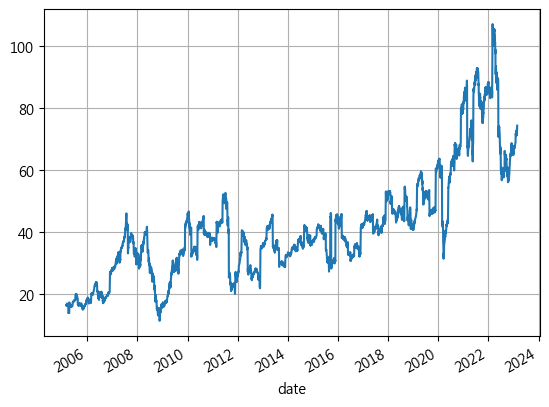

In [92]:
df_weight_detail[df_weight_detail['date'].isin(reb_lst) == False].groupby('date')['max_aum_assumption'].min().plot()

plt.grid()

plt.savefig(f'./figs/max_aum_assumption_{params_str}.png', dpi=300)

,SR_BENCH,SR_PORT,CAGR_BENCH,CAGR_PORT
0,0.5900,0.6200,0.0950,0.1175


,ALPHA,BETA,MEAN_DIV,TURNOVER(%)
0,0.0228,1.0410,5.1900,95.5100


In [ ]:
df_weight_detail = df_portfolio_value_detail_all.sort_values(['date','ticker']).reset_index(drop=True).copy()

# Compute the total value for each date
total_value = df_weight_detail.groupby('date')['value'].transform('sum')

# Compute the weight of each ticker by dividing its value by the total value for its date
df_weight_detail['weight'] = df_weight_detail['value'] / total_value

df_top_5_weighting = df_weight_detail.sort_values(['date','weight'], ascending = False).groupby('date').head(5).copy()
df_top_5_weighting = df_top_5_weighting.groupby('date')['weight'].sum().reset_index()
print("前5檔最大總和權重",df_top_5_weighting.max()['date'], round(df_top_5_weighting.max()['weight'], 4))

df_market_cap_copy = df_factor_all[['date','ticker','market_cap']].copy()

df_weight_detail = pd.merge(df_weight_detail, df_market_cap_copy, on = ['date','ticker'], how = 'left').copy()

df_weight_detail['max_aum_assumption'] = df_weight_detail['market_cap'] * 0.1 / df_weight_detail['weight'] / 1000000
df_weight_detail[df_weight_detail['date'].isin(reb_lst) == False].groupby('date')['max_aum_assumption'].min().plot()

plt.grid()

In [ ]:
df_weight_detail[df_weight_detail['max_aum_assumption'] < 40]

In [ ]:
series_sr

In [ ]:
series_sr